In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class DownConvLayer(nn.Module):
    def __init__(self, dim):
        super(DownConvLayer, self).__init__()
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        return x

以上代码定义了一个名为DownConvLayer的类，主要功能是实现了一个下采样卷积层，用于在卷积神经网络中进行特征提取和降维。在类的初始化方法中，定义了两个子模块。第一个子模块是使用nn.Conv2d函数定义的卷积层，输入和输出的通道数都是dim，卷积核大小为3x3，padding为1，表示在输入特征图周围填充一圈0，使得卷积操作后特征图大小不变。第二个子模块是nn.MaxPool2d，用于进行最大池化操作，将输入特征图尺寸缩小一半。在forward方法中，接收输入x，并通过卷积操作、ReLU激活函数和最大池化操作进行特征提取和降维，最后返回降维后的特征图。

In [3]:
# 创建一个DownConvLayer对象
down_conv = DownConvLayer(dim=1)
# 创建一个输入张量，假设尺寸为[batch_size, channel, height, width]
input_tensor = th.randn(1, 1, 28, 28)
# 将输入张量传递给DownConvLayer的forward方法进行前向计算
output_tensor = down_conv(input_tensor)
# 输出降维后的特征图尺寸
print(output_tensor.shape)

torch.Size([1, 1, 14, 14])


在测试用例中，我们创建了一个包含3个通道的输入张量，尺寸为[1, 3, 32, 32]。然后将输入张量传递给DownConvLayer的forward方法进行前向计算，得到输出张量output_tensor。最后打印输出张量的形状，可以看到输出特征图的尺寸被压缩了一半，即成为[1, 3, 16, 16]。

In [4]:
class UpConvLayer(nn.Module):
    def __init__(self, dim):
        super(UpConvLayer, self).__init__()
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.upsample(x)
        return x

以上代码定义了一个名为UpConvLayer的类，主要功能是实现了一个上采样卷积层，用于在卷积神经网络中进行特征上采样和提取更细致的特征。在类的初始化方法中，定义了两个子模块。第一个子模块是使用nn.Conv2d函数定义的卷积层，具体参数和作用与DownConvLayer一致。第二个子模块是nn.Upsample，用于进行上采样操作，通过指定scale_factor参数来确定上采样的倍数，mode参数设置为"nearest"表示使用最近邻插值。在forward方法中，接收输入x，并通过卷积操作、ReLU激活函数和上采样操作进行特征提取和上采样，最后返回上采样后的特征图。

In [5]:
# 创建一个UpConvLayer对象
up_conv = UpConvLayer(dim=1)
# 创建一个输入张量，假设尺寸为[batch_size, channel, height, width]
input_tensor = th.randn(1, 1, 14, 14)
# 将输入张量传递给UpConvLayer的forward方法进行前向计算
output_tensor = up_conv(input_tensor)
# 输出上采样后的特征图尺寸
print(output_tensor.shape)

torch.Size([1, 1, 28, 28])


在测试用例中，我们创建了一个包含3个通道的输入张量，尺寸为[1, 3, 16, 16]。然后将输入张量传递给UpConvLayer的forward方法进行前向计算，得到输出张量output_tensor。最后打印输出张量的形状，可以看到输出特征图的尺寸被放大了一倍，即成为[1, 3, 32, 32]。

In [6]:
class Encoder(nn.Module):
    def __init__(self, dim, layer_num=3):
        super(Encoder, self).__init__()
        self.convs = nn.ModuleList([DownConvLayer(dim) for _ in range(layer_num)])

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        return x

In [7]:
class Decoder(nn.Module):
    def __init__(self, dim, layer_num=3):
        super(Decoder, self).__init__()
        self.convs = nn.ModuleList([UpConvLayer(dim) for _ in range(layer_num)])
        self.final_conv = nn.Conv2d(dim, 1, 3, stride=1, padding=1)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        reconstruct = self.final_conv(x)
        return reconstruct

以上代码定义了一个Encoder类和一个Decoder类，分别用于实现编码器和解码器的功能。Encoder类中包含一个nn.ModuleList对象self.convs，根据layer_num参数的设置，通过循环创建layer_num个DownConvLayer实例，并将它们存储在self.convs中。在Encoder类的forward方法中，对于self.convs中的每个DownConvLayer实例，将输入x传递给它们进行特征提取和降维操作，并将结果作为下一个DownConvLayer的输入。最后返回最后一个DownConvLayer的输出结果。Decoder类中也包含一个nn.ModuleList对象self.convs，用于存储多个UpConvLayer类的实例，以及一个最终的卷积层self.final_conv。初始化方法与Encoder类类似，根据layer_num参数的设置，通过循环创建layer_num个UpConvLayer实例，并将它们存储在self.convs中。同时，创建一个卷积层self.final_conv，用于将解码器的输出特征图映射为最终的重建图像。在Decoder类的forward方法中，对于self.convs中的每个UpConvLayer实例，将输入x传递给它们进行特征上采样和提取更细致的特征操作，并将结果作为下一个UpConvLayer的输入。最后将最后一个UpConvLayer的输出结果通过self.final_conv进行卷积运算，得到最终的重建图像。

In [8]:
# 创建一个Encoder对象和一个Decoder对象
encoder = Encoder(dim=1, layer_num=2)
decoder = Decoder(dim=1, layer_num=2)
# 创建一个输入张量，假设尺寸为[batch_size, channel, height, width]
input_tensor = th.randn(1, 1, 28, 28)
# 将输入张量传递给Encoder的forward方法进行前向计算
encoded_tensor = encoder(input_tensor)
# 输出编码后图像的尺寸
print(encoded_tensor.shape)
# 将编码后的张量传递给Decoder的forward方法进行前向计算
reconstructed_tensor = decoder(encoded_tensor)
# 输出重建图像的尺寸
print(reconstructed_tensor.shape)

torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 28, 28])


In [9]:
class AutoEncoderModel(nn.Module):
    def __init__(self):
        super(AutoEncoderModel, self).__init__()
        self.encoder = Encoder(1, layer_num=1)
        self.decoder = Decoder(1, layer_num=1)

    def forward(self, inputs):
        latent = self.encoder(inputs)
        reconstruct_img = self.decoder(latent)
        return reconstruct_img

In [10]:
import torchvision
import torchvision.transforms as transforms

In [11]:
# 加载和预处理MNIST数据集
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = th.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# 创建自编码器模型实例、优化器和损失函数
model = AutoEncoderModel()
optimizer = th.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.MSELoss()
# 训练自编码器模型
num_epochs = 50
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
device

device(type='cuda')

In [13]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        optimizer.zero_grad()
        reconstructed_images = model(images)
        loss = criterion(images, reconstructed_images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished!")

Epoch [1/50], Loss: 0.1135
Epoch [2/50], Loss: 0.1075
Epoch [3/50], Loss: 0.1024
Epoch [4/50], Loss: 0.0979
Epoch [5/50], Loss: 0.0941
Epoch [6/50], Loss: 0.0909
Epoch [7/50], Loss: 0.0884
Epoch [8/50], Loss: 0.0864
Epoch [9/50], Loss: 0.0851
Epoch [10/50], Loss: 0.0842
Epoch [11/50], Loss: 0.0838
Epoch [12/50], Loss: 0.0828
Epoch [13/50], Loss: 0.0796
Epoch [14/50], Loss: 0.0757
Epoch [15/50], Loss: 0.0710
Epoch [16/50], Loss: 0.0659
Epoch [17/50], Loss: 0.0607
Epoch [18/50], Loss: 0.0560
Epoch [19/50], Loss: 0.0521
Epoch [20/50], Loss: 0.0490
Epoch [21/50], Loss: 0.0464
Epoch [22/50], Loss: 0.0439
Epoch [23/50], Loss: 0.0416
Epoch [24/50], Loss: 0.0394
Epoch [25/50], Loss: 0.0372
Epoch [26/50], Loss: 0.0351
Epoch [27/50], Loss: 0.0331
Epoch [28/50], Loss: 0.0312
Epoch [29/50], Loss: 0.0294
Epoch [30/50], Loss: 0.0277
Epoch [31/50], Loss: 0.0260
Epoch [32/50], Loss: 0.0244
Epoch [33/50], Loss: 0.0230
Epoch [34/50], Loss: 0.0216
Epoch [35/50], Loss: 0.0204
Epoch [36/50], Loss: 0.0193
E

In [14]:
import matplotlib.pyplot as plt

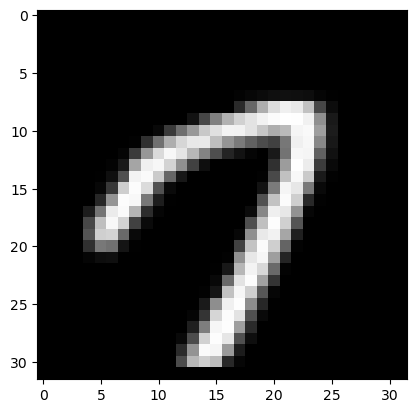

In [15]:
image = images[1].cpu().numpy()
image = image.squeeze()
plt.imshow(image, cmap="gray")
plt.show()

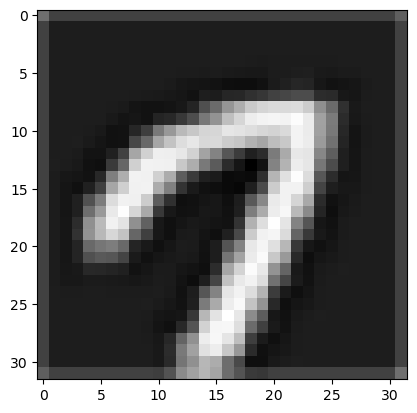

In [16]:
image = reconstructed_images[1].cpu().detach().numpy()
image = image.squeeze()
plt.imshow(image, cmap="gray")
plt.show()